In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [2]:
import time
import torch
from torch_geometric.loader import DataLoader
from tqdm import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

# from cutlass import *
# from rbfConv import *
from tqdm.notebook import tqdm
# from BasisConvolution.detail.cutlass import cutlass
from torch.nn.parameter import Parameter
import numpy as np
%matplotlib notebook

In [3]:
def plot2DNoise(xx,yy, noise):
    fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

    im = axis[0,0].pcolormesh(xx,yy,noise)
    axis[0,0].set_xlim(minDim,maxDim)
    axis[0,0].set_ylim(minDim,maxDim)
    axis[0,0].set_aspect('equal', adjustable='box')
    ax1_divider = make_axes_locatable(axis[0,0])
    # axis[0,0].axis('auto')
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    numCbar.ax.tick_params(labelsize=8) 

    im = axis[0,1].pcolormesh(xx,yy,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx - (maxDim - minDim),yy - (maxDim - minDim),np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx - (maxDim - minDim),yy + 0,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx - (maxDim - minDim),yy + (maxDim - minDim),np.hstack(noise).reshape(xx.shape))
    
    im = axis[0,1].pcolormesh(xx + 0,yy - (maxDim - minDim),np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx + 0,yy + (maxDim - minDim),np.hstack(noise).reshape(xx.shape))
    
    im = axis[0,1].pcolormesh(xx + (maxDim - minDim),yy - (maxDim - minDim),np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx + (maxDim - minDim),yy + 0,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx + (maxDim - minDim),yy + (maxDim - minDim),np.hstack(noise).reshape(xx.shape))
    
    ax1_divider = make_axes_locatable(axis[0,1])
    axis[0,1].set_xlim(minDim - (maxDim - minDim),maxDim + (maxDim - minDim))
    axis[0,1].set_ylim(minDim - (maxDim - minDim),maxDim + (maxDim - minDim))
    axis[0,1].set_aspect('equal', adjustable='box')
    # axis[0,1].axis('auto')
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    numCbar.ax.tick_params(labelsize=8) 

    axis[0,1].axvline(minDim, ls = '--', c = 'white', alpha = 0.5)
    axis[0,1].axvline(maxDim, ls = '--', c = 'white', alpha = 0.5)
    axis[0,1].axhline(minDim, ls = '--', c = 'white', alpha = 0.5)
    axis[0,1].axhline(maxDim, ls = '--', c = 'white', alpha = 0.5)

    fig.tight_layout()

In [4]:
from noise.generator import generatePerlin, generateSimplex, generateOctaveNoise

<IPython.core.display.Javascript object>


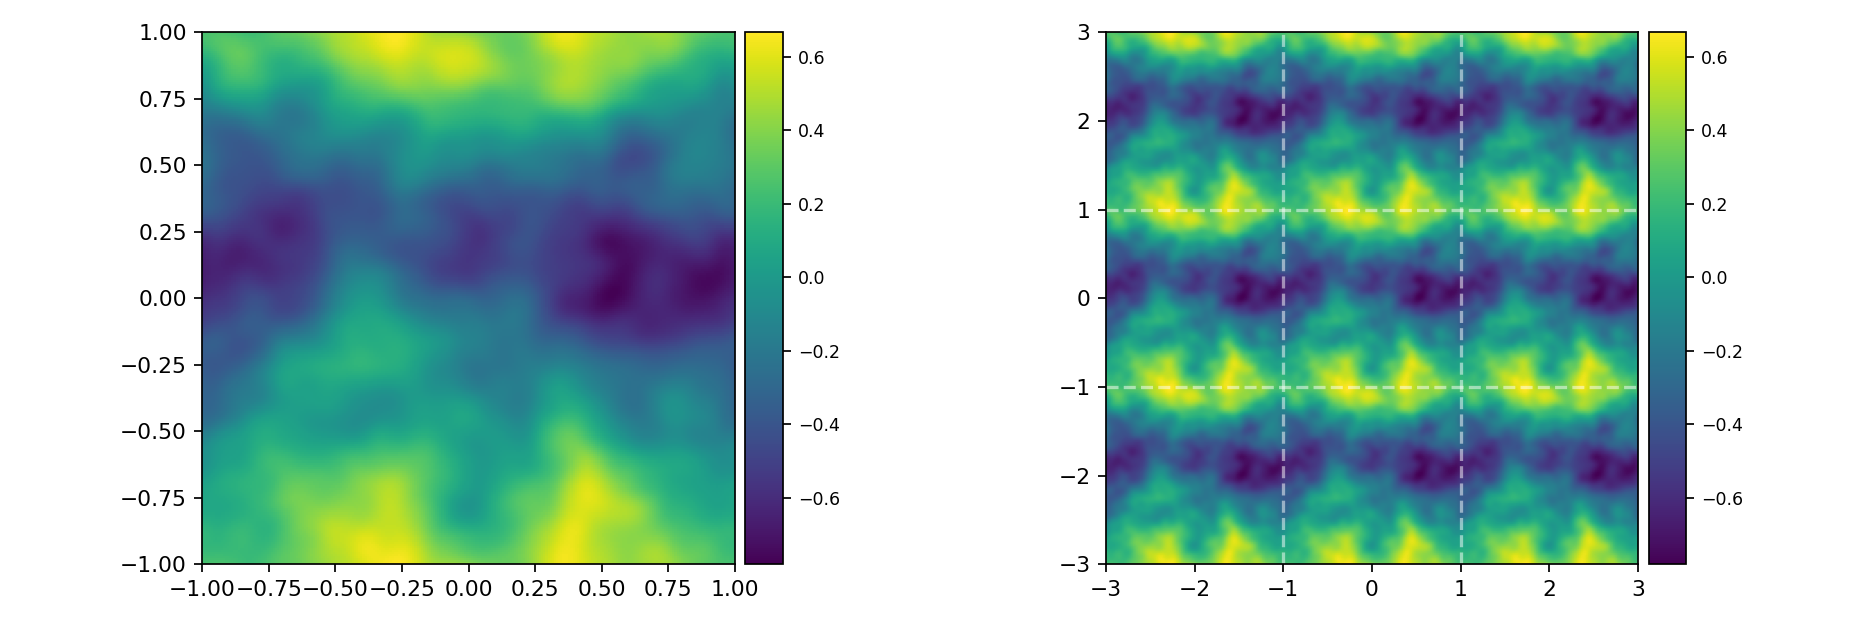

<IPython.core.display.Javascript object>


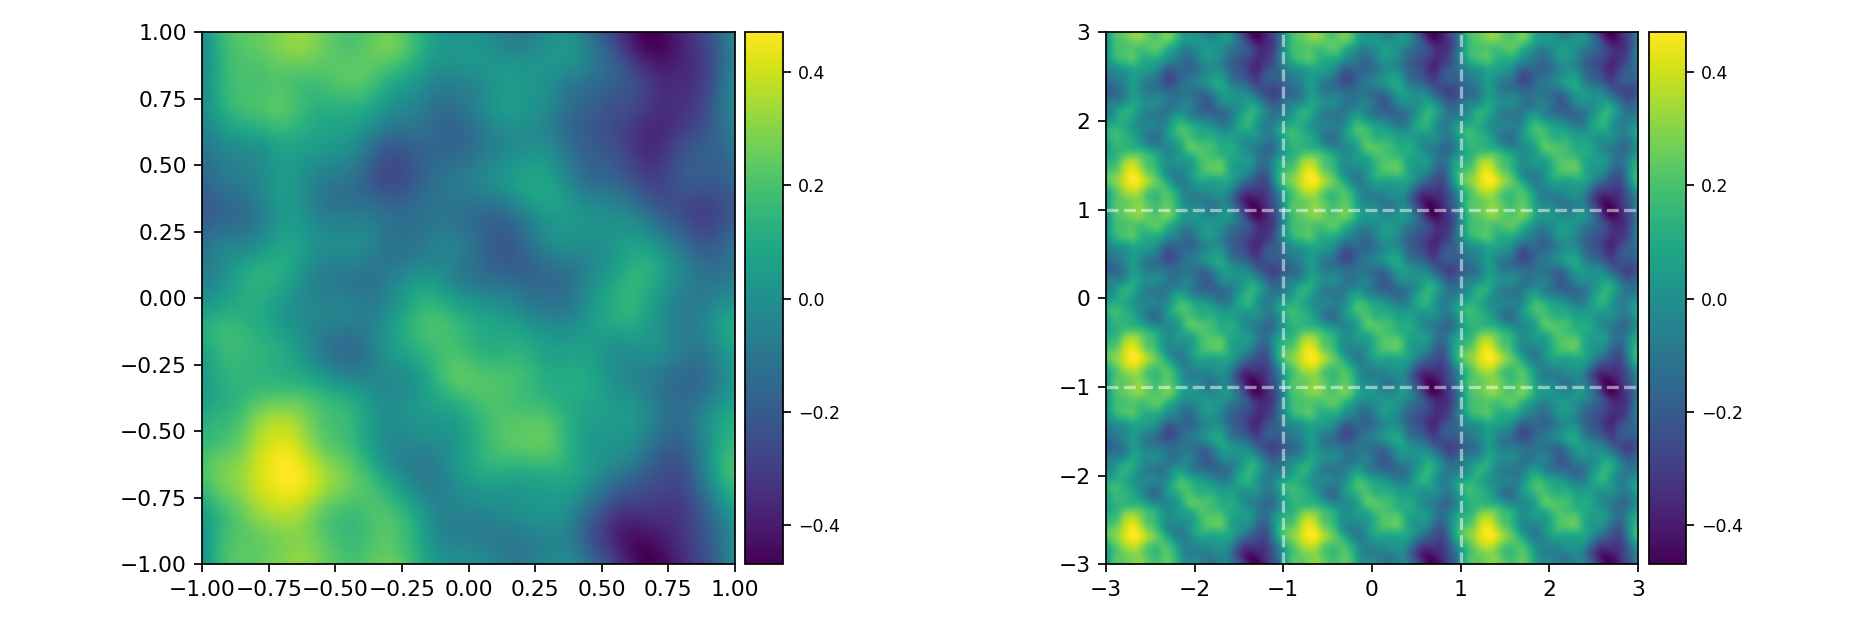

In [5]:
nx = ny = 256
minDim = -1
maxDim = 1
# perm, perm_grad_index3 = _init(12345)
x = np.linspace(minDim - (maxDim - minDim),maxDim + (maxDim - minDim), nx * 3)
y = np.linspace(minDim - (maxDim - minDim),maxDim + (maxDim - minDim), ny * 3)
xx,yy = np.meshgrid(x,y, indexing = 'xy')
p = np.stack((xx,yy), axis = -1).flatten().reshape((-1,2))
noise = []

xx, yy, noise = generateOctaveNoise(nx, octaves = 4, lacunarity = 2, persistence = 0.5, baseFrequency = 1, tileable = True, seed = 12345, kind = 'simplex')
plot2DNoise(xx.numpy(),yy.numpy(),noise.numpy())

xx, yy, noise = generateOctaveNoise(nx, octaves = 4, lacunarity = 2, persistence = 0.5, baseFrequency = 1, tileable = True, seed = 12345, kind = 'perlin')
plot2DNoise(xx.numpy(),yy.numpy(),noise.numpy())

In [66]:

def generateOctaveNoise(n, dim = 2, octaves = 4, lacunarity = 2, persistence = 0.5, baseFrequency = 1, tileable = True, kind = 'perlin', device = 'cpu', dtype = torch.float32, seed = 12345, normalized = True):
    freq = baseFrequency
    octave = 1
    amplitude = 1
    noise = torch.zeros([n] * dim, device = device, dtype = dtype)
    summedAmplitude = 0
    for i in range(octaves):
        result = generatePerlin(n, freq, dim = dim, tileable = tileable, device = device, dtype = dtype, seed = seed) if kind == 'perlin' else generateSimplex(n, freq = freq, dim = dim, tileable = tileable, device = device, dtype = dtype, seed = seed)
        resultNoise = result[-1] #/ (0.5 if kind == 'simplex' else 0.15)
#         resultNoise = resultNoise / torch.max(torch.abs(resultNoise))
        noise += amplitude * resultNoise
#         print('octave [%2d] - min: %g, mean: %g, max: %g - overall min: %g, mean: %g, max: %g' % (i, resultNoise.min(), resultNoise.mean(), resultNoise.max(), noise.min(), noise.max(), noise.mean()))
        freq *= lacunarity
#         summedAmplitude += amplitude
        amplitude *= persistence
    if normalized:
        noise = (noise  - torch.min(noise)) / (torch.max(noise) - torch.min(noise)) * 2 - 1
#     print('overall min: %g, mean: %g, max: %g' % (noise.min(), noise.max(), noise.mean()))
    return *result[:-1], noise

<IPython.core.display.Javascript object>


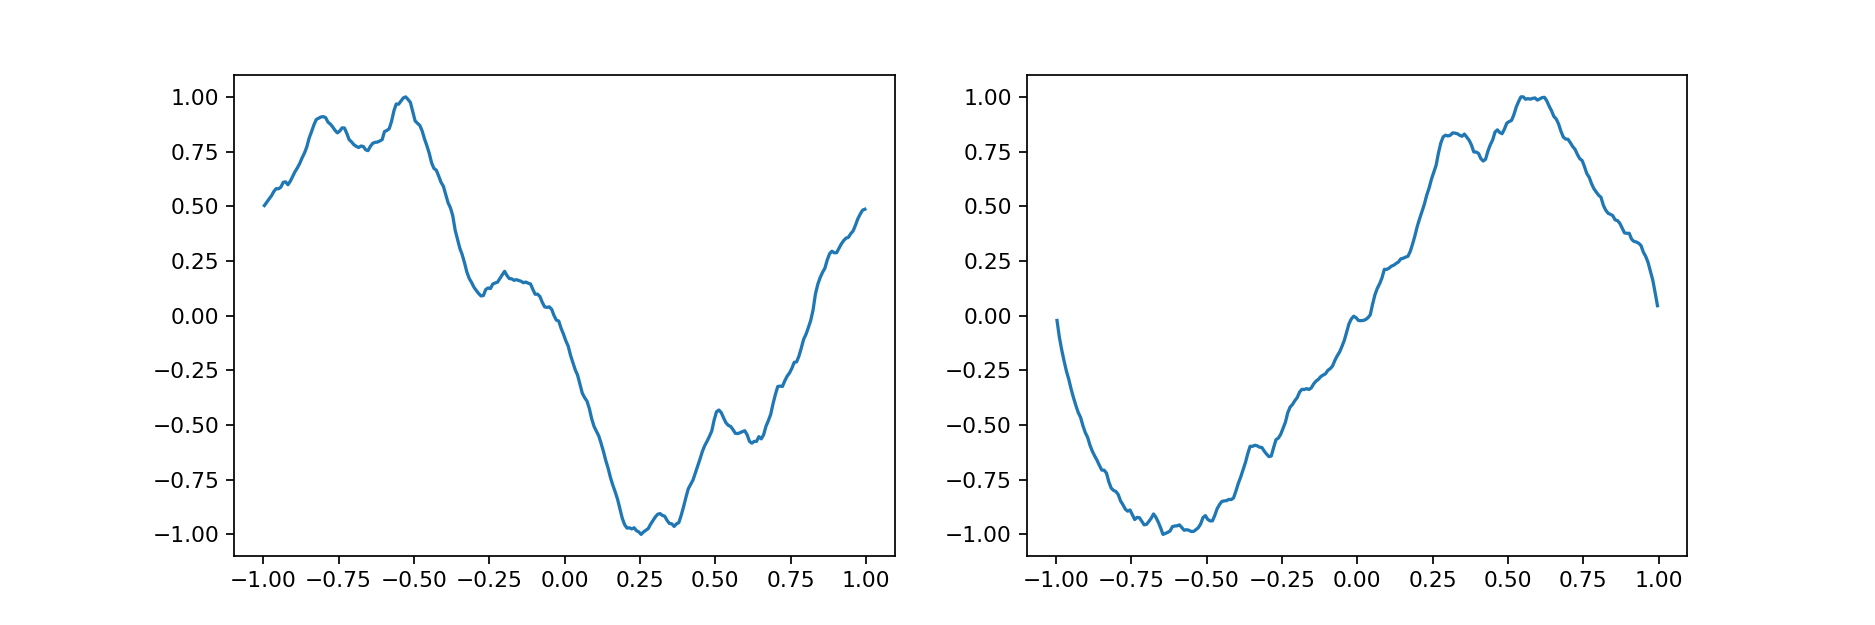

In [70]:
fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

xx, noise = generateOctaveNoise(nx, dim = 1, octaves = 8, lacunarity = 2, persistence = 0.5, baseFrequency = 1, tileable = True, seed = 12345, kind = 'simplex')
axis[0,0].plot(xx.numpy(), noise.numpy())

xx, noise = generateOctaveNoise(nx, dim = 1, octaves = 8, lacunarity = 2, persistence = 0.5, baseFrequency = 1, tileable = True, seed = 123456, kind = 'perlin')
axis[0,1].plot(xx.numpy(), noise.numpy())

In [13]:
 generateSimplex(nx, freq = freq, dim = 2, tileable = False, device = 'cpu', dtype = torch.float32, seed = 12345)

(tensor([[-0.9980, -0.9902, -0.9824,  ...,  0.9824,  0.9902,  0.9980],
         [-0.9980, -0.9902, -0.9824,  ...,  0.9824,  0.9902,  0.9980],
         [-0.9980, -0.9902, -0.9824,  ...,  0.9824,  0.9902,  0.9980],
         ...,
         [-0.9980, -0.9902, -0.9824,  ...,  0.9824,  0.9902,  0.9980],
         [-0.9980, -0.9902, -0.9824,  ...,  0.9824,  0.9902,  0.9980],
         [-0.9980, -0.9902, -0.9824,  ...,  0.9824,  0.9902,  0.9980]]),
 tensor([[-0.9980, -0.9980, -0.9980,  ..., -0.9980, -0.9980, -0.9980],
         [-0.9902, -0.9902, -0.9902,  ..., -0.9902, -0.9902, -0.9902],
         [-0.9824, -0.9824, -0.9824,  ..., -0.9824, -0.9824, -0.9824],
         ...,
         [ 0.9824,  0.9824,  0.9824,  ...,  0.9824,  0.9824,  0.9824],
         [ 0.9902,  0.9902,  0.9902,  ...,  0.9902,  0.9902,  0.9902],
         [ 0.9980,  0.9980,  0.9980,  ...,  0.9980,  0.9980,  0.9980]]),
 tensor([[ 0.3880,  0.3961,  0.3237,  ...,  0.4544,  0.2773,  0.0742],
         [ 0.4783,  0.4415,  0.3263,  ...,  0

<IPython.core.display.Javascript object>


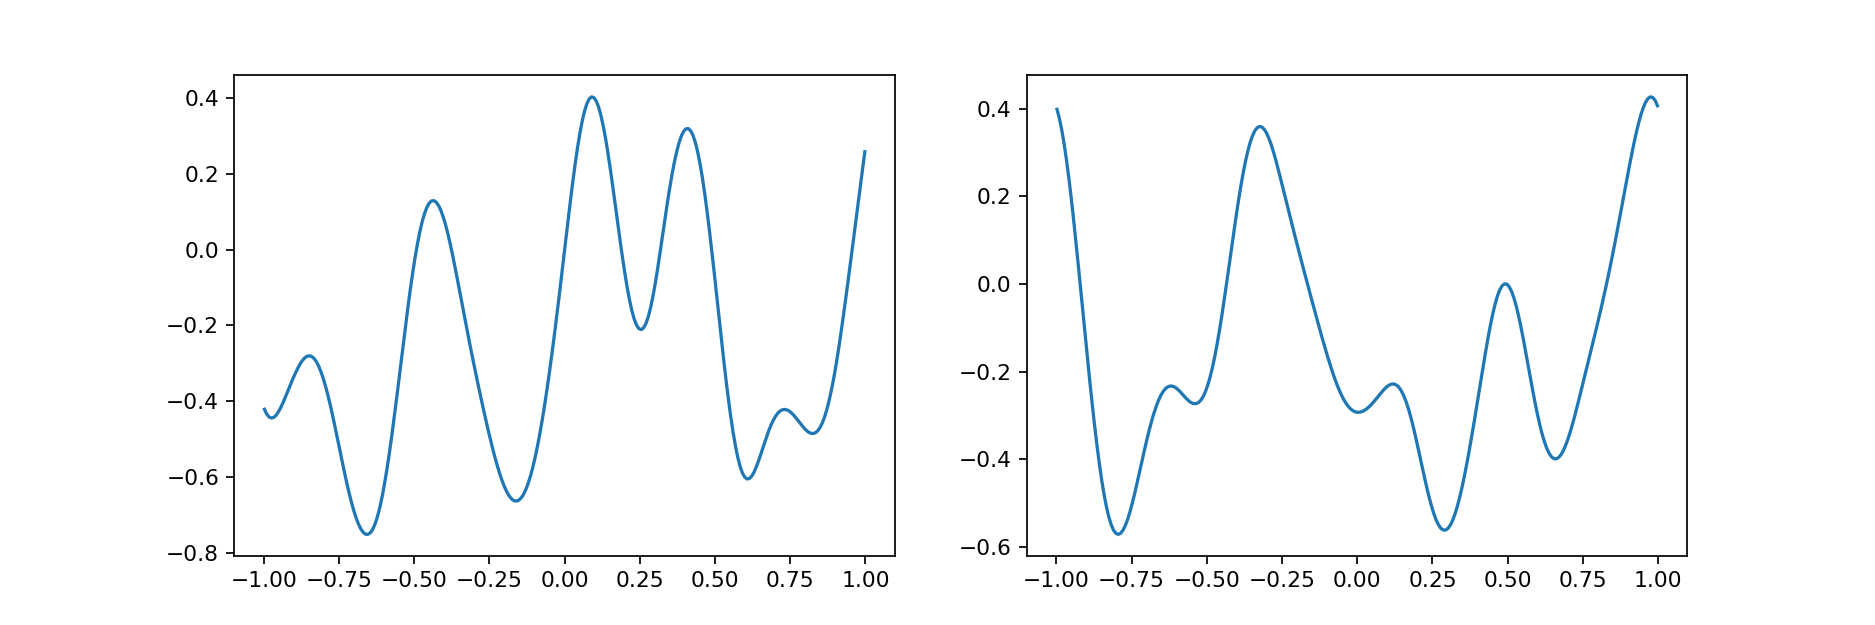

In [76]:
fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

xx, noise = generateSimplex(nx, freq = 4, dim = 1, seed = 42)
axis[0,0].plot(xx.numpy(), noise.numpy())

xx, noise = generateSimplex(nx, freq = 4, dim = 1, seed = 42, tileable = True)
axis[0,1].plot(xx.numpy(), noise.numpy())

# xx, yy, noise = perlinNoise2D([nx,ny], [2,2], [True, True], rng = np.random.default_rng(seed=42321))
# axis[0,0].plot(xx[0,:].numpy(), noise[0,:].numpy())

In [77]:
repeated = np.hstack((noise,noise,noise))
diff = np.diff(repeated)
print(repeated[nx-1:nx+2], diff[nx-1:nx+2])
print(repeated[2*nx-1:2*nx+2], diff[2*nx-1:2*nx+2])


[0.40634415 0.39818287 0.37762716] [-0.00816128 -0.0205557  -0.02609268]
[0.40634415 0.39818287 0.37762716] [-0.00816128 -0.0205557  -0.02609268]


<IPython.core.display.Javascript object>


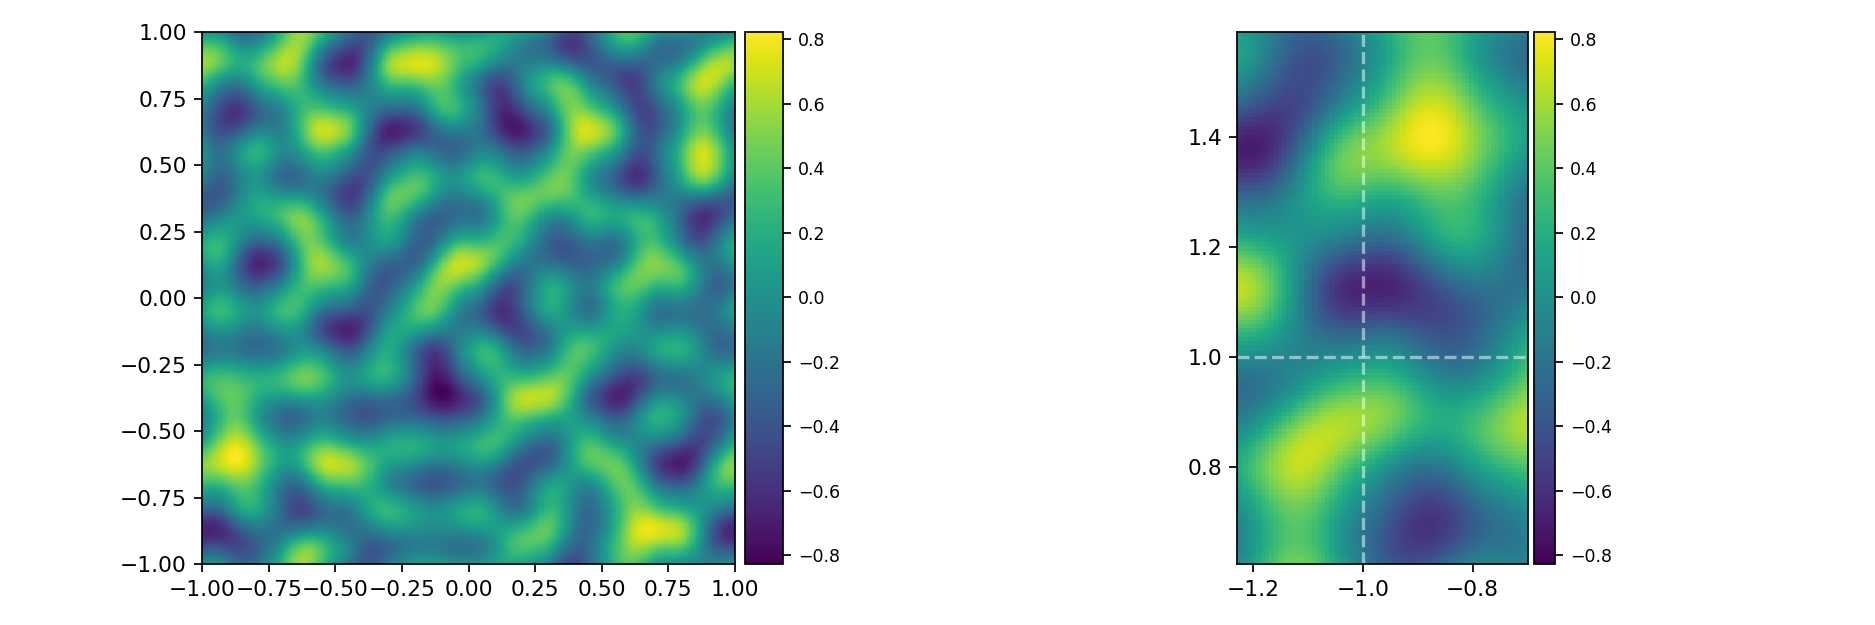

[ 0.04333563  0.         -0.0434498 ] [-0.04333563 -0.0434498  -0.04528882]
[ 0.04333563  0.         -0.0434498 ] [-0.04333563 -0.0434498  -0.04528882]


<IPython.core.display.Javascript object>


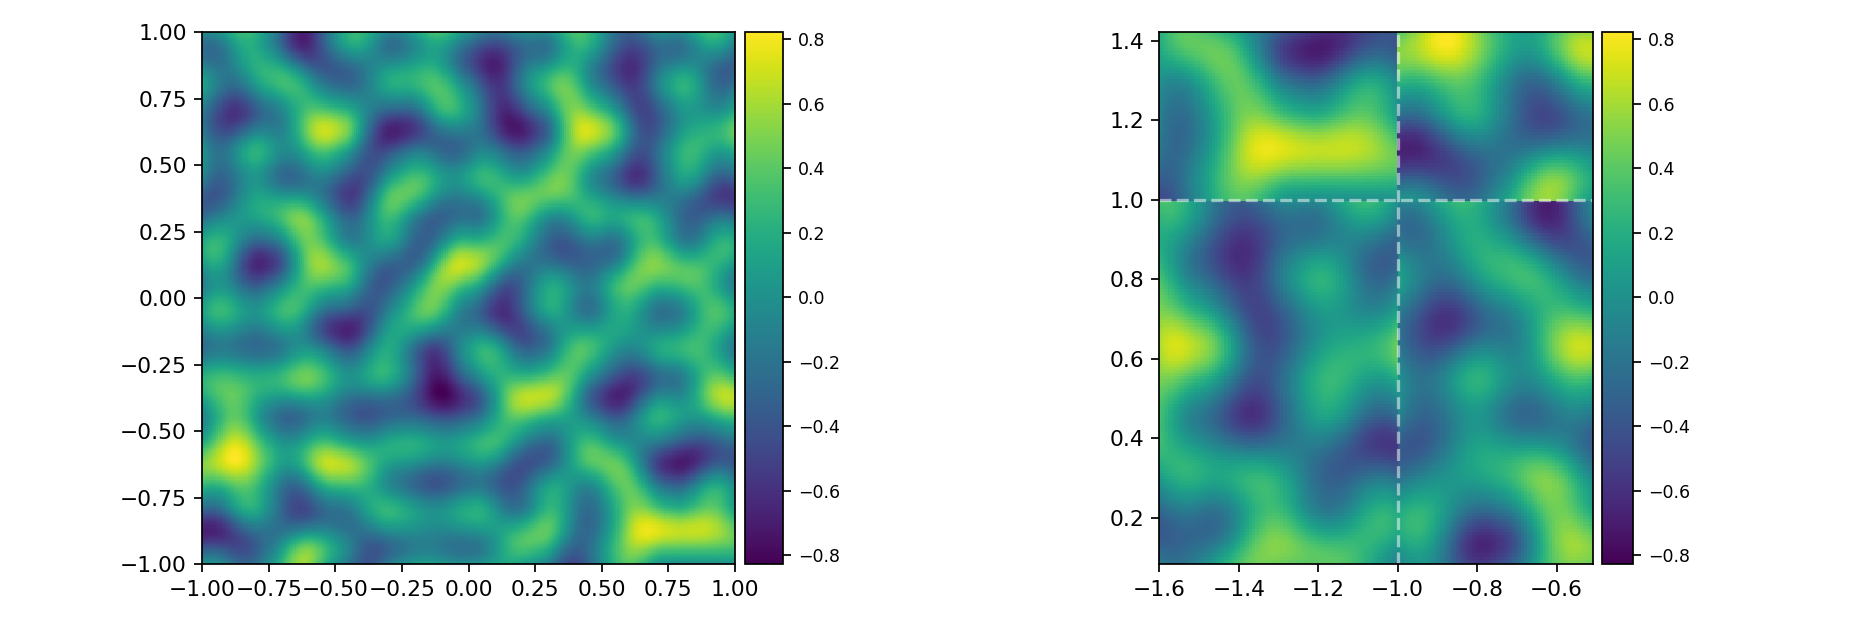

[-0.04330279  0.         -0.0434498 ] [ 0.04330279 -0.0434498  -0.04528882]
[-0.04330279  0.         -0.0434498 ] [ 0.04330279 -0.0434498  -0.04528882]


In [88]:
minDim = -1
maxDim = 1
xx, yy, noise = generatePerlin(nx, 8 , True, dim = 2,seed=42321)
plot2DNoisePerlin(xx.numpy(),yy.numpy(),noise.numpy())
repeated = np.hstack((noise[:,0],noise[:,0],noise[:,0]))
diff = np.diff(repeated)
print(repeated[nx-1:nx+2], diff[nx-1:nx+2])
print(repeated[2*nx-1:2*nx+2], diff[2*nx-1:2*nx+2])

xx, yy, noise = generatePerlin(nx, 8 , False, dim = 2,seed=42321)
plot2DNoisePerlin(xx.numpy(),yy.numpy(),noise.numpy())
repeated = np.hstack((noise[:,0],noise[:,0],noise[:,0]))
diff = np.diff(repeated)
print(repeated[nx-1:nx+2], diff[nx-1:nx+2])
print(repeated[2*nx-1:2*nx+2], diff[2*nx-1:2*nx+2])

<IPython.core.display.Javascript object>


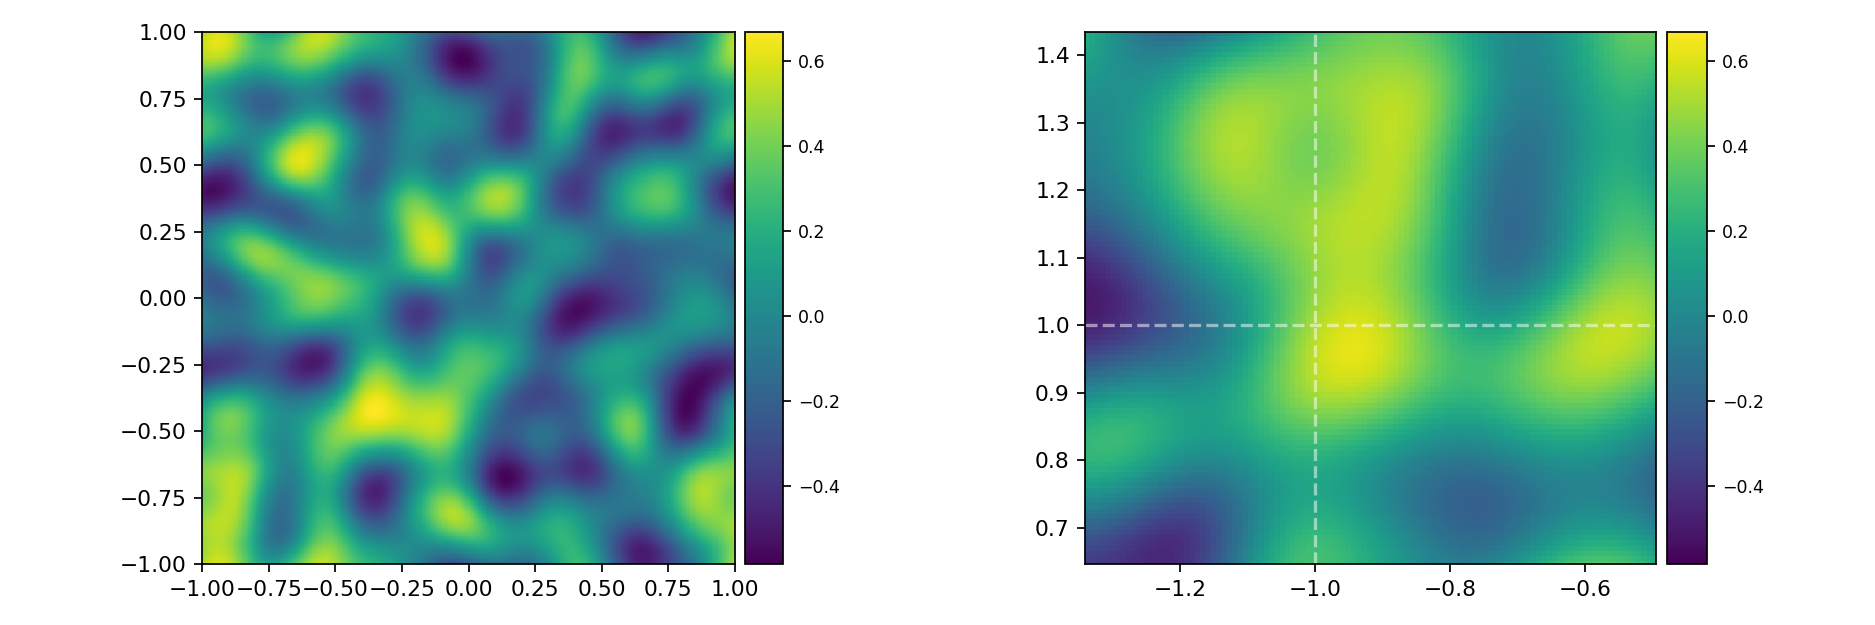

[0.516541   0.5120166  0.50293076] [-0.00452441 -0.00908583 -0.00879833]
[0.516541   0.5120166  0.50293076] [-0.00452441 -0.00908583 -0.00879833]


<IPython.core.display.Javascript object>


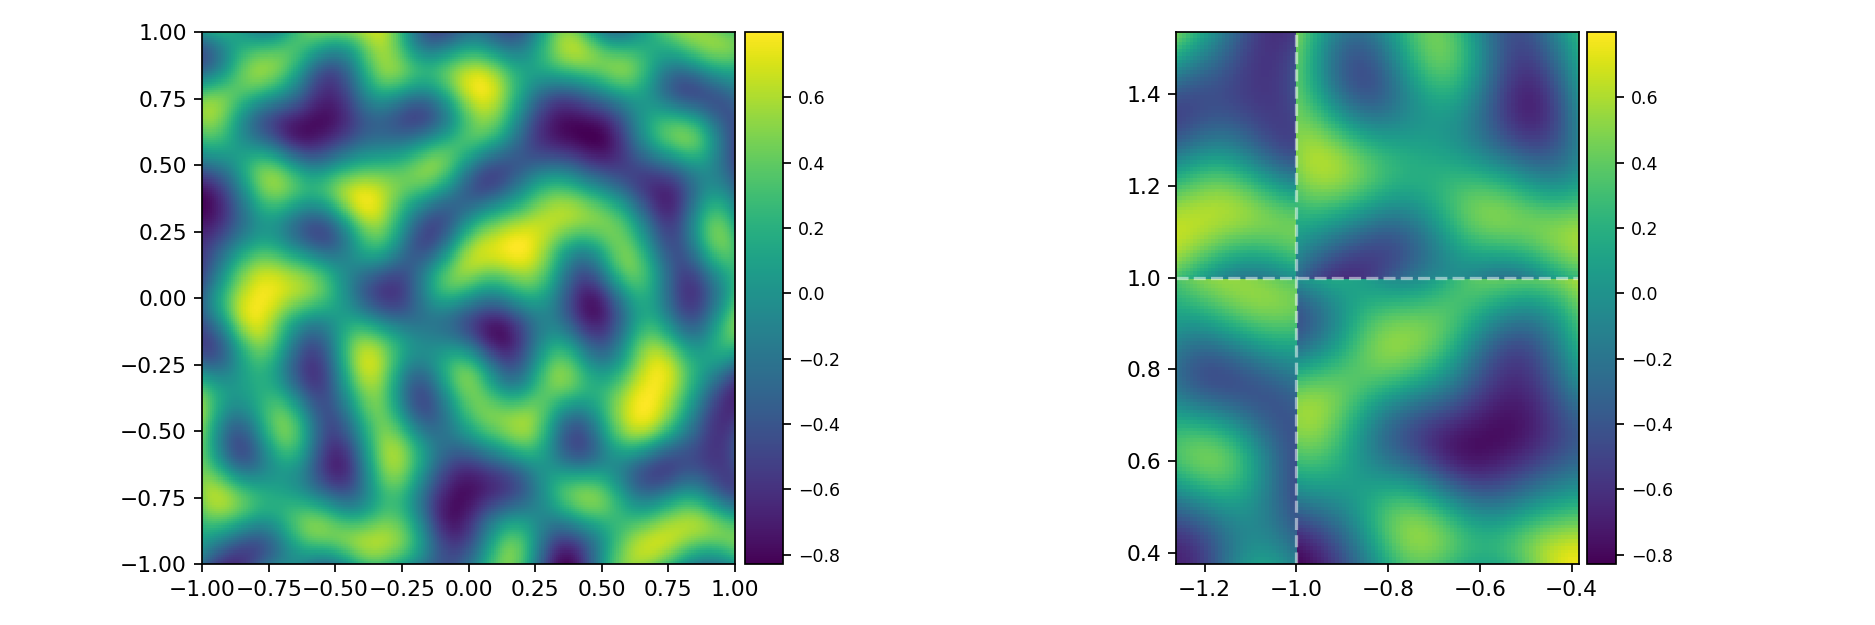

[-0.00797664 -0.25863874 -0.22895208] [-0.2506621   0.02968666  0.02991997]
[-0.00797664 -0.25863874 -0.22895208] [-0.2506621   0.02968666  0.02991997]


In [87]:
minDim = -1
maxDim = 1
xx, yy, noise = generateSimplex(nx, 4, tileable = True, dim = 2,seed=42321)
plot2DNoisePerlin(xx.numpy(),yy.numpy(),noise.numpy())
repeated = np.hstack((noise[:,0],noise[:,0],noise[:,0]))
diff = np.diff(repeated)
print(repeated[nx-1:nx+2], diff[nx-1:nx+2])
print(repeated[2*nx-1:2*nx+2], diff[2*nx-1:2*nx+2])

xx, yy, noise = generateSimplex(nx, 4, tileable = False, dim = 2,seed=42321)
plot2DNoisePerlin(xx.numpy(),yy.numpy(),noise.numpy())
repeated = np.hstack((noise[:,0],noise[:,0],noise[:,0]))
diff = np.diff(repeated)
print(repeated[nx-1:nx+2], diff[nx-1:nx+2])
print(repeated[2*nx-1:2*nx+2], diff[2*nx-1:2*nx+2])

In [66]:
repeated = np.hstack((noise[:,0],noise[:,0],noise[:,0]))
diff = np.diff(repeated)
print(repeated[nx-1:nx+2], diff[nx-1:nx+2])
print(repeated[2*nx-1:2*nx+2], diff[2*nx-1:2*nx+2])

[-0.09964044 -0.11021902 -0.1331169 ] [-0.01057858 -0.02289788 -0.0243718 ]
[-0.09964044 -0.11021902 -0.1331169 ] [-0.01057858 -0.02289788 -0.0243718 ]


In [188]:
minDim = -1
maxDim = 1
xx, yy, zz, noise = perlinNoise3D(nx, 2 , True, dim = 3, rng = np.random.default_rng(seed=42321))
# xx, yy, zz, noise = perlinNoise3D([nx,nx, nx], [2,2, 2], [True, True, True], rng = np.random.default_rng(seed=42321))

TypeError: perlinNoise3D() got an unexpected keyword argument 'dim'

In [45]:

    
plot2DNoisePerlin(xx[:,:,0].numpy(),yy[:,:,0].numpy(),noise[:,:,0].numpy())

IndexError: too many indices for tensor of dimension 2

In [156]:
xx, yy, noise = perlinNoise2D([nx,ny], [2,2], [True, True], rng = np.random.default_rng(seed=42321))

torch.Size([256]) torch.Size([256])


<IPython.core.display.Javascript object>


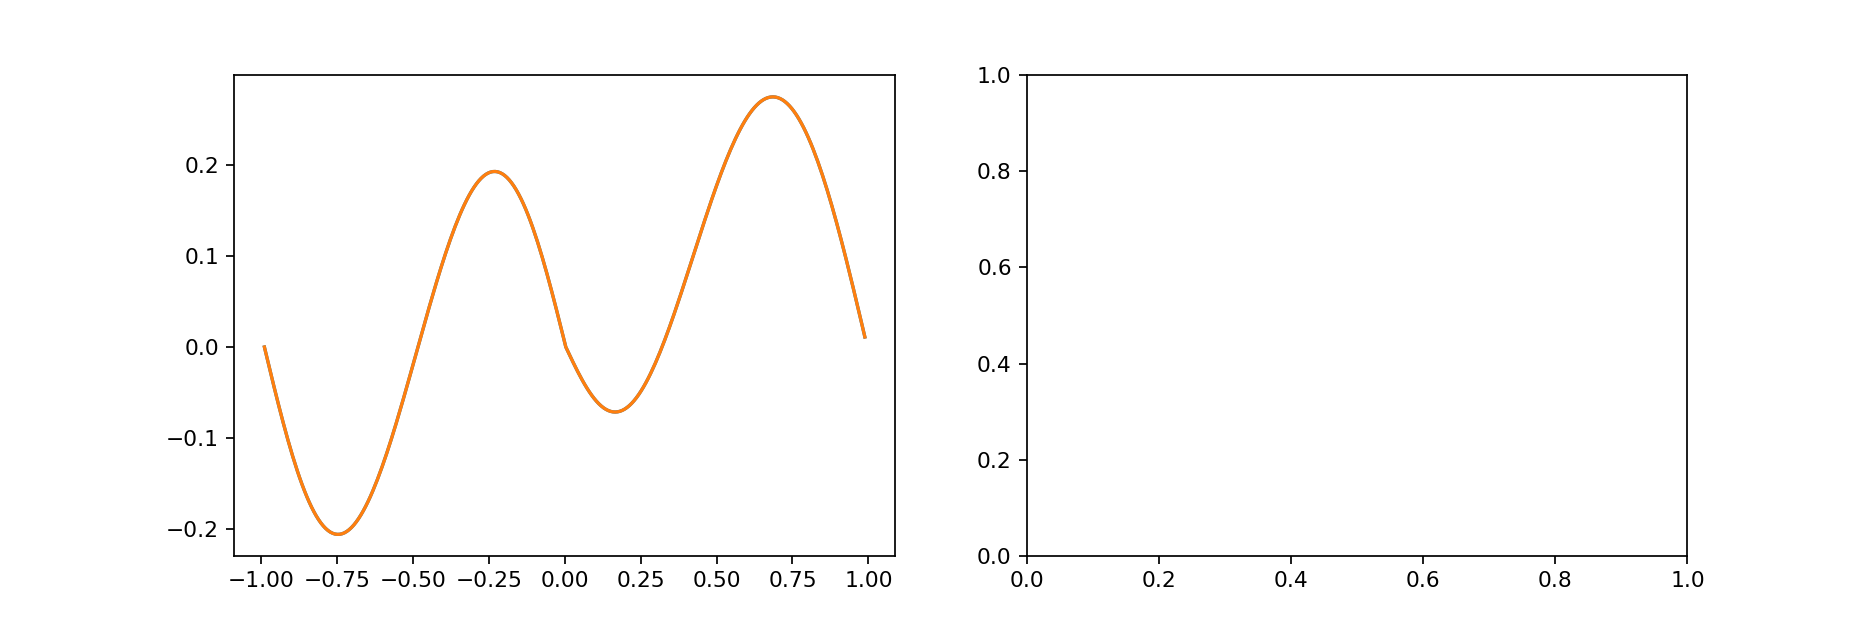

In [157]:
xx, noise = perlinNoise1D(nx, 2, True, rng = np.random.default_rng(seed=42321))
print(xx.shape, noise.shape)

fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

axis[0,0].plot(xx.numpy(), noise.numpy())

xx, yy, noise = perlinNoise2D([nx,ny], [2,2], [True, True], rng = np.random.default_rng(seed=42321))
axis[0,0].plot(xx[0,:].numpy(), noise[0,:].numpy())

In [ ]:
def noise3D(freq, res, kind = 'perlin', periodic = False, perlinArgs = {'shape': 256}, simplexArgs = None):

<IPython.core.display.Javascript object>


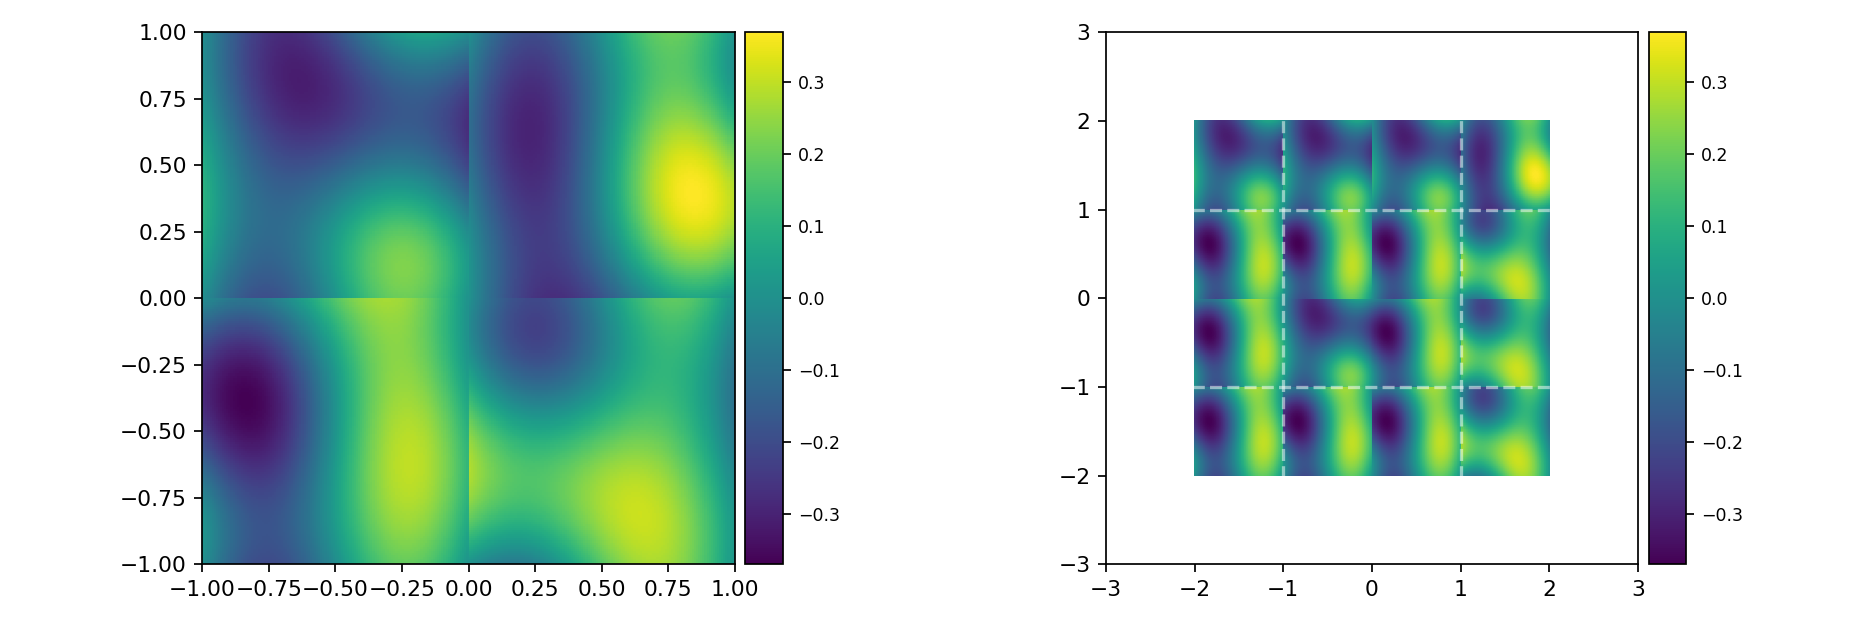

In [202]:
def plot2DNoisePerlin(xx,yy, noise):
    fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

    im = axis[0,0].pcolormesh(xx,yy,noise)
    axis[0,0].set_xlim(minDim,maxDim)
    axis[0,0].set_ylim(minDim,maxDim)
    axis[0,0].set_aspect('equal', adjustable='box')
    ax1_divider = make_axes_locatable(axis[0,0])
    # axis[0,0].axis('auto')
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    numCbar.ax.tick_params(labelsize=8) 

    im = axis[0,1].pcolormesh(xx,yy,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx - maxDim,yy - maxDim,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx - maxDim,yy + 0,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx - maxDim,yy + maxDim,np.hstack(noise).reshape(xx.shape))
    
    im = axis[0,1].pcolormesh(xx + 0,yy - maxDim,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx + 0,yy + maxDim,np.hstack(noise).reshape(xx.shape))
    
    im = axis[0,1].pcolormesh(xx + maxDim,yy - maxDim,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx + maxDim,yy + 0,np.hstack(noise).reshape(xx.shape))
    im = axis[0,1].pcolormesh(xx + maxDim,yy + maxDim,np.hstack(noise).reshape(xx.shape))
    
    ax1_divider = make_axes_locatable(axis[0,1])
    axis[0,1].set_xlim(minDim - (maxDim - minDim),maxDim + (maxDim - minDim))
    axis[0,1].set_ylim(minDim - (maxDim - minDim),maxDim + (maxDim - minDim))
    axis[0,1].set_aspect('equal', adjustable='box')
    # axis[0,1].axis('auto')
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    numCbar.ax.tick_params(labelsize=8) 

    axis[0,1].axvline(minDim, ls = '--', c = 'white', alpha = 0.5)
    axis[0,1].axvline(maxDim, ls = '--', c = 'white', alpha = 0.5)
    axis[0,1].axhline(minDim, ls = '--', c = 'white', alpha = 0.5)
    axis[0,1].axhline(maxDim, ls = '--', c = 'white', alpha = 0.5)

    fig.tight_layout()
    
xx,yy,noise = generate_perlin_noise_2d([nx,ny], [2,2], [True, True], rng = np.random.default_rng(seed=42321))
x = np.linspace(minDim, maxDim, nx * 1)
y = np.linspace(minDim, maxDim, ny * 1)
xx,yy = np.meshgrid(x,y, indexing = 'xy')
plot2DNoisePerlin(xx,yy,noise)

In [42]:
repeated = np.hstack((noise[:,0],noise[:,0],noise[:,0]))
diff = np.diff(repeated)
print(repeated[nx-1:nx+2], diff[nx-1:nx+2])
print(repeated[2*nx-1:2*nx+2], diff[2*nx-1:2*nx+2])

[ 0.04333563  0.         -0.0434498 ] [-0.04333563 -0.0434498  -0.04528882]
[ 0.04333563  0.         -0.0434498 ] [-0.04333563 -0.0434498  -0.04528882]


  0%|          | 0/589824 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


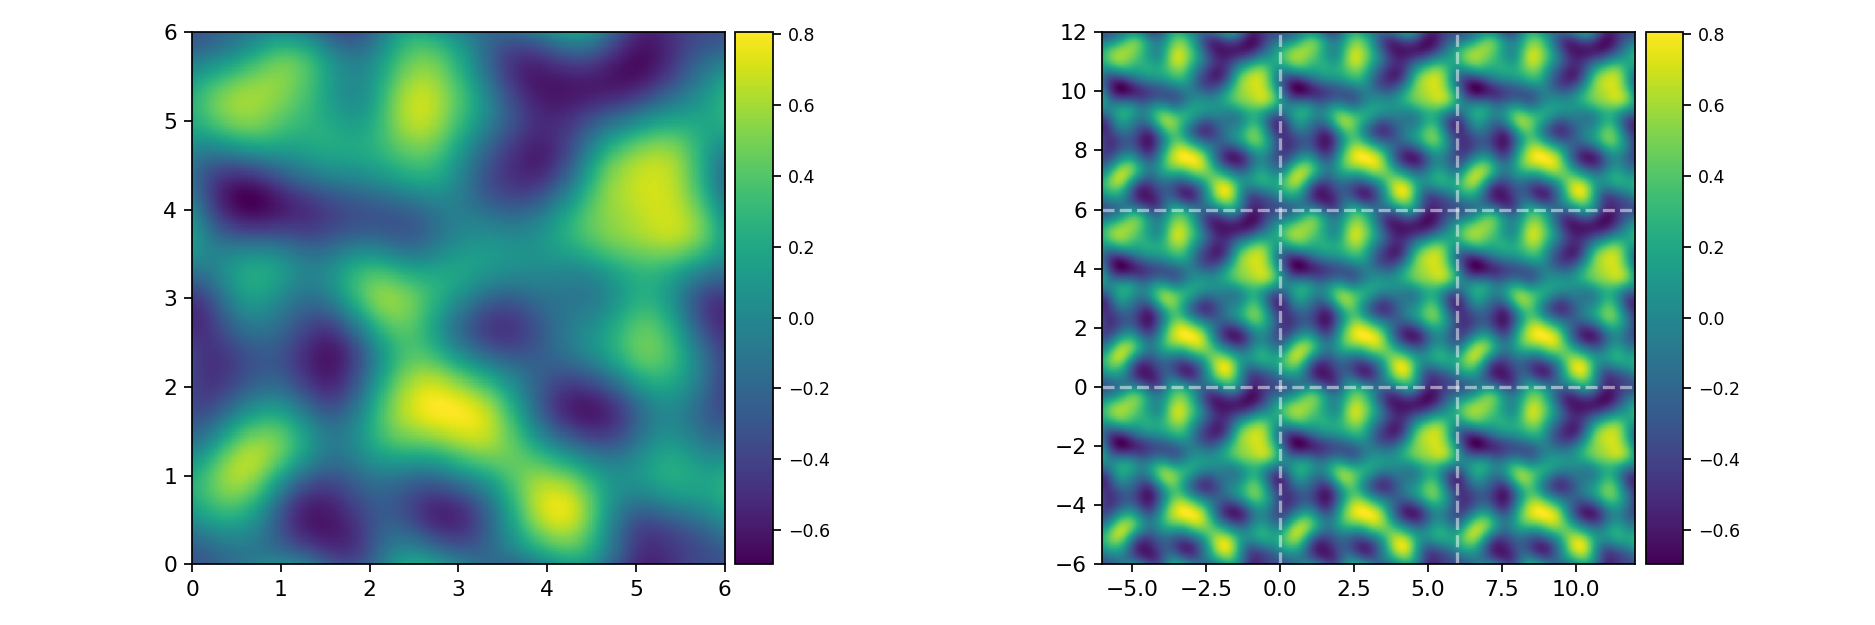

In [56]:
nx = ny = 256
minDim = 0
maxDim = 6
perm, perm_grad_index3 = _init(12345)
dx = (maxDim - minDim) * 3 / (nx * 3)
x = np.linspace(minDim - 1*(maxDim - minDim) + dx / 2,maxDim + 1*(maxDim - minDim) - dx/2, nx * 3)
y = np.linspace(minDim - 1*(maxDim - minDim) + dx / 2,maxDim + 1*(maxDim - minDim) - dx/2, ny * 3) + dx / 2
xx,yy = np.meshgrid(x,y, indexing = 'xy')
p = np.stack((xx,yy), axis = -1).flatten().reshape((-1,2))
noise = []
freq = 1
freq2 = 1
for position in tqdm(p):
    noiseValue = _noise3periodic(position[0] * freq + freq, position[1]*freq + freq, 0, perm, perm_grad_index3, w6 = 1 * freq2, h6 = 1 * freq2, d6 = 1 * freq2, wrap = 6)
#     noiseValue += _noise3periodic(position[0] * freq * 2 + freq * 2, position[1]*freq * 2 + freq * 2, 0, perm, perm_grad_index3, w6 = 1 * freq2 * 2, h6 = 1 * freq2 * 2, d6 = 1 * freq2 * 2, wrap = 6)
#     noiseValue += _noise3periodic(position[0] * freq * 4 + freq * 4, position[1]*freq * 4 + freq * 4, 0, perm, perm_grad_index3, w6 = 1 * freq2 * 4, h6 = 1 * freq2 * 4, d6 = 1 * freq2 * 4, wrap = 6)
    noise.append(noiseValue)
#     noise.append(_noise3(position[0]*6, position[1]*6, 0, perm, perm_grad_index3))
noise = np.hstack(noise).reshape(xx.shape)
plot2DNoise(xx,yy,noise)

In [57]:
repeated = np.hstack((noise[:,0],noise[:,0],noise[:,0]))
repeated = np.hstack((noise[0,:],noise[0,:],noise[0,:]))
diff = np.diff(repeated)
print(repeated[nx-2:nx+3], diff[nx-2:nx+3])
print(repeated[2*nx-2:2*nx+3], diff[2*nx-2:2*nx+3])

[-0.31349681 -0.30757176 -0.30140635 -0.29499096 -0.28832009] [0.00592505 0.0061654  0.00641539 0.00667087 0.00692638]
[-0.31349681 -0.30757176 -0.30140635 -0.29499096 -0.28832009] [0.00592505 0.0061654  0.00641539 0.00667087 0.00692638]


In [1]:

import scipy.fft as sfft
# Then, to calculate the fft and shift the spectrum, use :
f = noise
# nx = ny = 256
# x = np.linspace(0,1, nx * 3)
# y = np.linspace(0,1, ny * 3)
# xx,yy = np.meshgrid(x,y, indexing = 'xy')
# f = np.sin(xx * np.pi * 16) * np.cos(yy * np.pi * 16)
# n = nx * 3

Z_fft = sfft.fft2(f)
Z_shift = sfft.fftshift(Z_fft)


fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
n = f.shape[0]  # Size of the grid in one dimension
dx = np.abs(xx[0, 1] - xx[0, 0])  # Grid spacing in the x-direction
dy = np.abs(yy[1, 0] - yy[0, 0])  # Grid spacing in the y-direction
# Define the frequency axes
fx = np.fft.fftfreq(n, dx)
fy = np.fft.fftfreq(n, dy)

# im = axis[0,0].pcolormesh(fx, fy, np.abs(Z_shift))
# axis[0,0].contourf(fx, fy, np.abs(Z_shift), cmap='viridis')
im = axis[0,0].imshow(np.abs(Z_shift), extent=(fx.min(), fx.max(), fy.min(), fy.max()) , norm = colors.LogNorm(vmin = 1e-8, vmax = psd.max()))
axis[0,0].set_xscale('symlog')
axis[0,0].set_yscale('symlog')

axis[0,1].pcolormesh(xx,yy,f)
axis[0,1].set_aspect('equal', adjustable='box')
fig.colorbar(im)

# plt.figure(4)
# plt.imshow(np.abs(Z_shift))

NameError: name 'noise' is not defined

In [ ]:
1 / (2 * np.pi / n) / 2

In [ ]:
fx.max()

In [ ]:
fx = sfft.fftshift(sfft.fftfreq(n,dx))
fy = sfft.fftshift(sfft.fftfreq(n,dx))
ffx, ffy = np.meshgrid(fx,fy)
r = np.sqrt(ffx**2 + ffy**2)

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
im = axis[0,0].imshow(r)
axis[0,1].pcolormesh(ffx,ffy,r)
fig.colorbar(im)


In [ ]:
binScale = 2
fx = sfft.fftshift(sfft.fftfreq(n,dx))
fy = sfft.fftshift(sfft.fftfreq(n,dx))
ffx, ffy = np.meshgrid(fx,fy)
r = np.sqrt(ffx**2 + ffy**2)

# Create an array to store the radial average
radial_psd = np.zeros((int(np.max(r)) ) * binScale + 1)

# Calculate the radial average
for i in range(nx*3):
    for j in range(ny*3):
        radial_psd[int(r[i, j] * binScale)] += np.abs(Z_shift[i, j])**2

# Normalize the radial average
count = np.bincount((r * binScale).astype(int).ravel())
radial_psd[count > 0] /= count[count > 0]

# print(radial_psd)
# print(count)

fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

axis[0,1].plot(np.arange(len(radial_psd)) / binScale, radial_psd)
axis[0,1].set_xscale('log')
axis[0,1].set_yscale('log')

axis[0,1].axhline(radial_psd.max(), ls = '--', c = 'black', alpha = 0.5)
axis[0,1].axvline(radial_psd.argmax() / binScale, ls = '--', c = 'black', alpha = 0.5)

axis[0,1].set_title('Radial PSD, max: %g @ %d' % (radial_psd.max(), radial_psd.argmax() / binScale))

In [ ]:
radial_psd.argmax()

In [ ]:
import matplotlib.colors as colors

nx = ny = 8
x = np.linspace(-np.pi, np.pi, nx * 3)
y = np.linspace(-np.pi, np.pi, ny * 3)
xx,yy = np.meshgrid(x,y, indexing = 'xy')
f = np.sin(xx) #* np.cos(yy)
plot2DNoise(xx,yy,f)


n = nx * 3
# Compute the 2D FFT of f
fft_f = np.fft.fft2(f)
# Compute the magnitude of the FFT
magnitude = np.abs(fft_f)

# Normalize the magnitude to get the PSD
psd = magnitude**2 / (n * n)
# Compute the frequency axes
n = f.shape[0]  # Size of the grid in one dimension
dx = np.abs(xx[0, 1] - xx[0, 0])  # Grid spacing in the x-direction
dy = np.abs(yy[1, 0] - yy[0, 0])  # Grid spacing in the y-direction
print(dx,dy)
# Define the frequency axes
fx = np.fft.fftfreq(n, dx)
fy = np.fft.fftfreq(n, dy)

# Shift the axes to center the zero frequency component
fx = np.fft.fftshift(fx)
fy = np.fft.fftshift(fy)

In [ ]:
psd.max()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure()

# Create a contour plot of the magnitude of the 2D FFT
plt.contourf(fx, fy, np.abs(fft_f), cmap='viridis')
# plt.imshow(psd, extent=(fx.min(), fx.max(), fy.min(), fy.max()) , norm = colors.LogNorm(vmin = 1e-3, vmax = psd.max()))
# plt.pcolormesh(fx,fy, psd, norm = colors.LogNorm(vmin = 1e-3, vmax = psd.max()))
# plt.imshow(psd, norm = colors.LogNorm(vmin = 1e-3, vmax = psd.max()))

# Set axis labels and title
plt.xlabel('Frequency in x-direction')
plt.ylabel('Frequency in y-direction')
plt.title('2D FFT Magnitude')

# Show a colorbar
plt.colorbar()

# Show the plot
plt.show()

In [ ]:
# Calculate the radial frequency components
r = np.sqrt(fx**2 + fy**2)

# Create an array to store the radial average
radial_psd = np.zeros(int(np.max(r)) + 1)

# Calculate the radial average
for i in range(nx):
    for j in range(ny):
        radial_psd[int(r[i, j])] += psd[i, j]

# Normalize the radial average
count = np.bincount(r.astype(int).ravel())
radial_psd /= count[1:]